# Diffusion of a Gaussian function

Author: Jørgen S. Dokken

Let us now solve a more interesting problem, namely the diffusion of a Gaussian hill. We take the initial value to be
\begin{align}
    u_0(x,y)&= e^{-ax^2-ay^2}
\end{align}
for $a=5$ on the domain $[-2,2]\times[-2,2]$. For this problem we will use homogeneous Dirichlet boundary conditions ($u_D=0$).

The first difference from the previous problem is that we are not using a unit square. We create the rectangular domain with `dolfinx.mesh.create_rectangle`.

In [1]:
import matplotlib.pyplot as plt
import pyvista
import ufl
import numpy as np
import dolfinx

from petsc4py import PETSc
from mpi4py import MPI

from dolfinx import fem, mesh, io, plot
from dolfinx.fem.petsc import assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc

# Define temporal parameters
t = 0  # Start time
T = 0.5  # Final time
num_steps = 50
dt = T / num_steps  # time step size

# Define mesh
###################### THis part need to replace later, to a brake disc

# nx and ny is the number of elements
# np.array([-1,-1]) is the 
nx, ny = 20, 20
domain = mesh.create_rectangle(MPI.COMM_WORLD, [np.array([-1, -1]), np.array([1, 1])],
                               [nx, ny], mesh.CellType.triangle)

# this 1 means first order of lagrange polynominal
V = fem.FunctionSpace(domain, ("Lagrange", 1))

/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
print(np.array([-1, -1]))

[-1 -1]


Note that we have used a much higher resolution that before to better resolve features of the solution.
We also easily update the intial and boundary conditions. Instead of using a class to define the initial condition, we simply use a function

In [3]:
# Create initial condition

# x[0] is x, and x[1] is y
# def initial_condition(x, a=5):
    #return np.exp(-a * (x[0]**2 + x[1]**2))

# apply to all the x
def initial_condition(x):
     return (5 + x[0]-x[0])
    
u_n = fem.Function(V)
u_n.name = "u_n"
u_n.interpolate(initial_condition)

# Create boundary condition
fdim = domain.topology.dim - 1

# x.sharpe
boundary_facets = mesh.locate_entities_boundary(
    domain, fdim, lambda x: np.full(x.shape[1], True, dtype=bool))

## PETSC.Scalarype(X), this X is the value of boundary condition, like inlet temperature is 20, then here X is 20.
# Scalartype means constant value.
bc = fem.dirichletbc(PETSc.ScalarType(1), fem.locate_dofs_topological(V, fdim, boundary_facets), V)


In [4]:
print('1:fdim is','\n', fdim)
print('2: boundary_facets is', '\n', boundary_facets)
print('bc is','\n', bc)


1:fdim is 
 1
2: boundary_facets is 
 [   0    3    4    6   12   14   23   25   37   39   54   56   74   76
   97   99  123  125  152  154  184  186  219  221  257  259  298  300
  342  344  389  391  439  441  492  494  548  550  607  609  668  669
  671  726  728  780  782  831  833  879  881  924  926  966  968 1005
 1007 1041 1043 1074 1076 1104 1106 1131 1133 1155 1157 1176 1178 1194
 1196 1209 1211 1221 1223 1230 1232 1236 1238 1239]
bc is 


## Time-dependent output
To visualize the solution in an external program such as Paraview, we create a an `XDMFFile` which we can store multiple solutions in. The main advantage with an XDMFFile, is that we only need to store the mesh once, and can append multiple solutions to the same grid, reducing the storage space.
The first argument to the XDMFFile is which communicator should be used to store the data. As we would like one output, independent of the number of processors, we use the `COMM_WORLD`. The second argument is the file name of the output file, while the third argument is the state of the file,
this could be read (`"r"`), write (`"w"`) or append (`"a"`).

In [5]:
xdmf = io.XDMFFile(domain.comm, "diffusion.xdmf", "w")
xdmf.write_mesh(domain)

# Define solution variable, and interpolate initial solution for visualization in Paraview
uh = fem.Function(V)
uh.name = "uh"
uh.interpolate(initial_condition)
xdmf.write_function(uh, t)

In [6]:
print(uh.name)
print(uh)


uh
uh


## Variational problem and solver
As in the previous example, we prepare objects for time dependent problems, such that we do not have to recreate data-structures.

In [7]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
a = u * v * ufl.dx + dt * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = (u_n + dt * f) * v * ufl.dx

## Preparing linear algebra structures for time dependent problems
We note that even if `u_n` is time dependent, we will reuse the same function for `f` and `u_n` at every time step. We therefore call `dolfinx.fem.form` to generate assembly kernels for the matrix and vector.

In [8]:
# assembly matrix and vector

bilinear_form = fem.form(a)
linear_form = fem.form(L)

We observe that the left hand side of the system, the matrix $A$ does not change from one time step to another, thus we only need to assemble it once. However, the right hand side, which is dependent on the previous time step `u_n`, we have to assemble it every time step. Therefore, we only create a vector `b` based on `L`, which we will reuse at every time step.

In [9]:
A = assemble_matrix(bilinear_form, bcs=[bc])
A.assemble()
b = create_vector(linear_form)

In [10]:
print(b.view())
#print(A.view())

None
Vec Object: 1 MPI processes
  type: mpi
Process [0]
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0.
0

## Using petsc4py to create a linear solver
As we have already assembled `a` into the matrix `A`, we can no longer use the `dolfinx.fem.petsc.LinearProblem` class to solve the problem. Therefore, we create a linear algebra solver using PETSc, and assign the matrix `A` to the solver, and choose the solution strategy.

In [11]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

## Visualization of time dependent problem using pyvista
We use the DOLFINx plotting functionality, which is based on pyvista to plot the solution at every $15$th time step. We would also like to visualize a colorbar reflecting the minimal and maximum value of $u$ at each time step. We use the following convenience function `plot_function` for this:

In [12]:
import matplotlib as mpl
pyvista.start_xvfb()

grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))

plotter = pyvista.Plotter()
plotter.open_gif("u_time.gif", fps=30)

grid.point_data["uh"] = uh.x.array
warped = grid.warp_by_scalar("uh", factor=1)


viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)

renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            clim=[0, max(uh.x.array)])

## Updating the solution and right hand side per time step
To be able to solve the variation problem at each time step, we have to assemble the right hand side and apply the boundary condition before calling
`solver.solve(b, uh.vector)`. We start by resetting the values in `b` as we are reusing the vector at every time step.
The next step is to assemble the vector, calling `dolfinx.fem.petsc.assemble_vector(b, L)` which means that we are assemble the linear for `L(v)` into the vector `b`. Note that we do not supply the boundary conditions for assembly, as opposed to the left hand side.
This is because we want to use lifting to apply the boundary condition, which preserves symmetry of the matrix $A$ if the bilinear form $a(u,v)=a(v,u)$ without Dirichlet boundary conditions.
When we have applied the boundary condition, we can solve the linear system and update values that are potentially shared between processors.
Finally, before moving to the next time step, we update the solution at the previous time step to the solution at this time step.

In [13]:
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    warped = grid.warp_by_scalar("uh", factor=1)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
plotter.close()
xdmf.close()

  warnings.warn(

  warnings.warn(



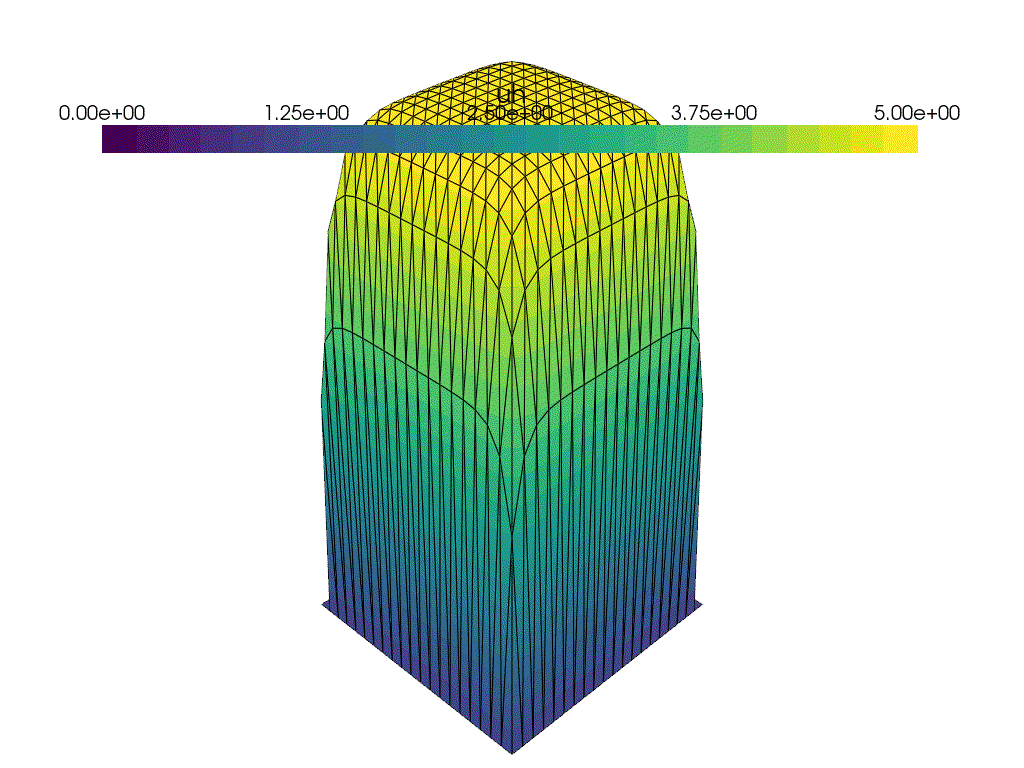

In [14]:
# Display the GIF
from IPython.display import display, Image

display(Image(filename = 'u_time.gif'))

## Animation with Paraview
We can also use Paraview to create an animation. We open the file in paraview with `File->Open`, and then press `Apply` in the properties panel.

Then, we add a time-annotation to the figure, pressing: `Sources->Alphabetical->Annotate Time` and `Apply` in the properties panel. It Is also a good idea to select an output resolution, by pressing `View->Preview->1280 x 720 (HD)`.

Then finally, click `File->Save Animation`, and save the animation to the desired format, such as `avi`, `ogv` or a sequence of `png`s. Make sure to set the framerate to something, sensible, in the range of $5-10$ frames per second.

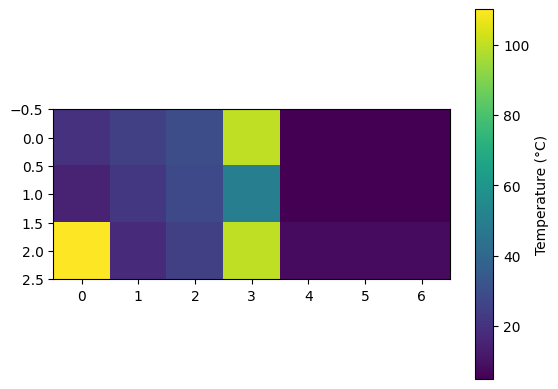

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a 2D array representing temperature values in each region of the rectangle
# Replace this array with your actual temperature data
temperature_data = np.array([
    [20, 25, 30, 100,5,5,5],
    [15, 22, 28, 50,5,5,5],
    [110, 18, 25, 100,8,8,8]
])

# Create a heat map using Matplotlib's imshow function
plt.imshow(temperature_data, cmap='viridis', interpolation='nearest')

# Add colorbar to show temperature scale
plt.colorbar(label='Temperature (°C)')

# Show the plot
plt.show()